# Predicting NDVI trends with Gradient Boosting Regression Trees

## Overview

- **Key ideas:**
    - Basically, this notebook investigates the same problem formulated in `ndvi_trends_gbrt_xgboost.ipynb`, with some minor differences:
        - Here we want to test different scores for training extreme gradient boosted trees in cross validation settings: `negative root mean squared error`, `negative mean absolute error`, and `R square`.
        - Use all those scores with [multi-metric evaluation on GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py), that is, a exhaustive search for the best model in a hyper parameter grid. The decisive score for defining the best model is `negative root mean squared error`. 
        - Apply [sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) to all features, just after the application of [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to the unique single categorical feature representing 2015 land class of pixel. Note that scaling data is not necessary for tree-based models, and we do it here just for didactic purposes. Then, we use [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for linear dimensionality reduction in order to decrease computation cost of search in hyper parameter grid. Finally, we apply [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) (Yeo-Johnson) to these principal components in order to make the resulting data distribution more Gaussian. _This last step can be time consuming, and maybe it does not bring performance increase_.
        - Spatial distributions for train-test data split and for relative error prediction.

## Initial setup

In [1]:
# Load packages.
import sys
import warnings
import sklearn 

import numpy as np
import pandas as pd
import xarray as xr 
import sklearn as skl
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (make_scorer, 
                             mean_squared_error,  
                             mean_absolute_error,
                             r2_score)
from sklearn.inspection import permutation_importance, partial_dependence

# Better visualization.
xr.set_options(display_style="text")

# No messages.
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* pandas:", pd.__version__)
print("* xarray:", xr.__version__)
print("* scikit-learn:", skl.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* pandas: 1.1.1
* xarray: 0.16.0
* scikit-learn: 0.23.2

>>> Computer:
* Hostname: n008
* User: sandroal
* Directory: /work/sandroal/notebooks/modelling
* Date: Wed Dec  9 18:11:09 BRST 2020
* CPUs: 40


In [3]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 1.67 s, sys: 332 ms, total: 2 s
Wall time: 2.85 s


In [4]:
# Where figures will be put.
FIG_FOLDER = "/work/sandroal/images/modelling/"

# Final results.
save_fig = True

# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Decadal variation in slopes.
factor = 120 * 2

# Significance global threshold (decadal variation).
u = 0.0192

## Load data matrix

In [5]:
%%time

# Data file path.
ppdatafp = "/work/sandroal/data_sets/FEATURES/ndvi_trends.csv"

# Load data in a pandas DataFrame object.
df_matrix = pd.read_csv(ppdatafp)

# Show it.
print("=== Data with and without statistical significance in NDVI trends ===")
print("\n>>> Columns:", df_matrix.columns)
print("\n>>> Shape", df_matrix.shape)
print()
df_matrix.head()

=== Data with and without statistical significance in NDVI trends ===

>>> Columns: Index(['lat', 'lon', 'elev', 'lclass_2015', 'lclass_2001_2015_dcount',
       'p_mean', 'p_std', 'p_slope', 'tmax_mean', 'tmax_std', 'tmax_slope',
       'tmin_mean', 'tmin_std', 'tmin_slope', 'srad_mean', 'srad_std',
       'srad_slope', 'pdsi_mean', 'pdsi_std', 'pdsi_slope', 'ndvi_mean',
       'ndvi_std', 'protected_area', 'ndvi_slope'],
      dtype='object')

>>> Shape (228646, 24)

CPU times: user 856 ms, sys: 72 ms, total: 928 ms
Wall time: 929 ms


,lat,lon,elev,lclass_2015,lclass_2001_2015_dcount,p_mean,p_std,p_slope,tmax_mean,tmax_std,...,srad_mean,srad_std,srad_slope,pdsi_mean,pdsi_std,pdsi_slope,ndvi_mean,ndvi_std,protected_area,ndvi_slope
0,-55.875000,-67.208333,26.987129,0,0,0.0,0.0,0.0,8.587447,3.013888,...,94.502431,62.982034,0.0,-0.984239,2.501392,-2.016802,0.625084,0.057361,1,0.007261
1,-55.875000,-67.125000,188.500253,9,0,0.0,0.0,0.0,8.217287,2.945910,...,93.347908,62.116514,0.0,-0.970170,2.470640,-1.943672,0.630312,0.051792,1,-0.017732
2,-55.708333,-67.458333,194.751892,0,0,0.0,0.0,0.0,8.102003,3.111487,...,88.917352,59.173952,0.0,-0.890400,2.401116,-1.850004,0.633719,0.084883,1,0.002685
3,-55.708333,-67.375000,74.248263,0,0,0.0,0.0,0.0,8.356106,3.116774,...,91.725914,60.506976,0.0,-0.954349,2.465468,-1.972234,0.641481,0.087672,1,0.003421
4,-55.708333,-67.291667,10.247289,0,0,0.0,0.0,0.0,8.532316,3.118584,...,93.856327,61.865061,0.0,-0.982610,2.496296,-2.000002,0.667822,0.085308,1,-0.004208


In [6]:
df_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228646 entries, 0 to 228645
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   lat                      228646 non-null  float64
 1   lon                      228646 non-null  float64
 2   elev                     228646 non-null  float64
 3   lclass_2015              228646 non-null  int64  
 4   lclass_2001_2015_dcount  228646 non-null  int64  
 5   p_mean                   228646 non-null  float64
 6   p_std                    228646 non-null  float64
 7   p_slope                  228646 non-null  float64
 8   tmax_mean                228646 non-null  float64
 9   tmax_std                 228646 non-null  float64
 10  tmax_slope               228646 non-null  float64
 11  tmin_mean                228646 non-null  float64
 12  tmin_std                 228646 non-null  float64
 13  tmin_slope               228646 non-null  float64
 14  srad

In [7]:
# Summary statistics.
df_matrix.drop(labels=["lat", "lon", "lclass_2015", "protected_area"], axis="columns").describe()

,elev,lclass_2001_2015_dcount,p_mean,p_std,p_slope,tmax_mean,tmax_std,tmax_slope,tmin_mean,tmin_std,tmin_slope,srad_mean,srad_std,srad_slope,pdsi_mean,pdsi_std,pdsi_slope,ndvi_mean,ndvi_std,ndvi_slope
count,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000
mean,585.551326,0.223275,63.712404,50.623752,0.421719,27.103458,2.366252,0.283127,15.789759,2.216654,0.310940,182.852251,37.781894,-0.197442,-0.025660,2.777918,-0.137154,0.625376,0.071869,0.002138
std,912.754930,0.666124,37.953218,23.022120,2.050873,6.198829,1.756277,0.295784,7.023440,1.446057,0.283527,25.503492,19.177504,6.928412,0.887116,0.491867,1.194424,0.230013,0.033023,0.009460
min,1.000000,0.000000,0.000000,0.000000,-20.374601,-2.476180,0.501048,-0.701302,-16.666155,0.391691,-0.576002,79.556168,13.136532,-31.351333,-3.432126,0.261838,-5.924686,-0.300002,0.000002,-0.125887
25%,106.000266,0.000000,34.757871,36.263082,0.000000,24.276435,1.130342,0.151899,12.458019,0.880073,0.107780,166.399154,23.707840,-3.660298,-0.558334,2.474363,-0.909088,0.534098,0.051355,-0.002617
50%,265.000000,0.000000,62.647967,52.800910,0.000000,29.928171,1.530255,0.329899,18.498248,1.840865,0.299998,184.691427,30.378333,0.714286,0.106522,2.702161,-0.243017,0.661429,0.068069,0.002303
75%,603.000117,0.000000,88.772142,66.324301,0.895280,31.379107,3.188571,0.480003,21.099398,3.255106,0.509224,199.076537,46.245999,4.166667,0.609541,3.005709,0.543209,0.831446,0.090375,0.007266
max,6478.749815,10.000000,353.047128,183.721048,28.466404,34.783032,7.236874,1.019600,26.232127,6.720710,1.045872,256.847229,94.205595,17.285319,3.477175,79.731226,4.842106,0.916129,0.271057,0.175385


## Preprocess and split data

In [8]:
%%time

# Numeric data (float and int). 
numeric_features = [
    "lclass_2001_2015_dcount",
    "lat", "lon", "elev", 
    "p_mean", "p_std", "p_slope",
    "tmax_mean", "tmax_std", "tmax_slope",
    "tmin_mean", "tmin_std", "tmin_slope", 
    "srad_mean", "srad_std", "srad_slope", 
    "pdsi_mean", "pdsi_std", "pdsi_slope", 
    "ndvi_mean", "ndvi_std"
]

# Categorical data.
categorical_features = ["lclass_2015", "protected_area"]

# Target.
target = ["ndvi_slope"]

# Inputs.
features = categorical_features + numeric_features

# Reduce number of instances: only trends with statistical significance
mask_stat_sig = df_matrix.ndvi_slope.abs() >= u
df_matrix = df_matrix[mask_stat_sig]

# Simple train-test split as pandas DataFrame objects.
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_matrix[features], 
    df_matrix[target], 
    test_size=0.3, 
    stratify=df_matrix.lclass_2015
)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 14.8 ms


In [9]:
print(">>> Protected area pixels:")
df_matrix.protected_area.value_counts()

>>> Protected area pixels:


0    10552
1     1600
Name: protected_area, dtype: int64

In [10]:
mask_pa = df_matrix.protected_area == int(1)
mask_pos = df_matrix.ndvi_slope > 0
print(">>> Protected area pixels:")
print("* positive trend:", (mask_pos & mask_pa).sum())
print("* negative trend:", (~mask_pos & mask_pa).sum())
print("\n>>> Non protected area pixels:")
print("* positive trend:", (mask_pos & ~mask_pa).sum())
print("* negative trend:", (~mask_pos & ~mask_pa).sum())

>>> Protected area pixels:
* positive trend: 1058
* negative trend: 542

>>> Non protected area pixels:
* positive trend: 6169
* negative trend: 4383


In [11]:
print(">>> All data:")
print("* Positive trends:", np.sum(df_matrix.ndvi_slope > 0))
print("* Negative trends:", np.sum(df_matrix.ndvi_slope < 0))
print("\n>>> Train set:")
print("* Positive trends:", np.sum(df_y_train.ndvi_slope > 0))
print("* Negative trends:", np.sum(df_y_train.ndvi_slope < 0))
print("\n>>> Test set:")
print("* Positive trends:", np.sum(df_y_test.ndvi_slope > 0))
print("* Negative trends:", np.sum(df_y_test.ndvi_slope < 0))

>>> All data:
* Positive trends: 7227
* Negative trends: 4925

>>> Train set:
* Positive trends: 5052
* Negative trends: 3454

>>> Test set:
* Positive trends: 2175
* Negative trends: 1471


CPU times: user 80 ms, sys: 16 ms, total: 96 ms
Wall time: 184 ms


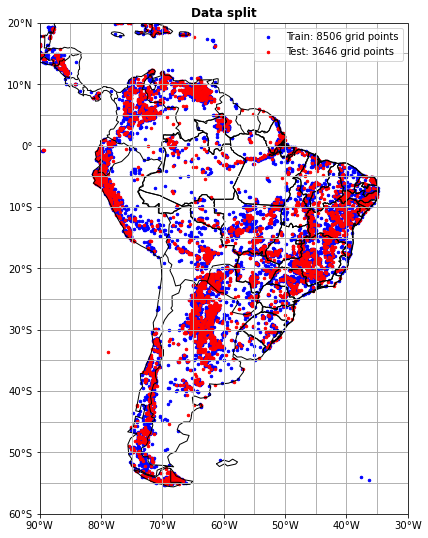

In [12]:
%%time

# Map for train - test split.
sca = 1.10
axgr = cdlearn.maps.south_america(
    figsize=(6 * sca, 12 * sca), 
    nrows_ncols=(1, 1),
    axes_pad=0.50,
    titles=["Data split"],
    cbar_mode="none"
)

# Train.
_ = axgr[0].scatter(
    x=df_x_train["lon"].values, 
    y=df_x_train["lat"].values, 
    s=25,
    marker=".", 
    color="blue",
    label=f"Train: {df_x_train.shape[0]} grid points"
)

# Test.
_ = axgr[0].scatter(
    x=df_x_test["lon"].values, 
    y=df_x_test["lat"].values, 
    s=25,
    marker=".", 
    color="red",
    label=f"Test: {df_x_test.shape[0]} grid points"
)

# Legends.    
_ = axgr[0].legend(loc=1)

## Train XGBRT model with GridSearchCV

In [13]:
# One hot encoding.
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder())]
)

# Column-wise transformations by feature type.
one_hot_preprocessor = ColumnTransformer(
    transformers=[("categorical", categorical_transformer, categorical_features)],
    remainder="passthrough"
)

# Append model to preprocessing pipeline. Now we have a full prediction pipeline. 
# For tree-based models it is not necessary to scale data. We do it here just for 
# learning purposes.
model_xgbrt = Pipeline(
    steps=[
        ("one_hot", one_hot_preprocessor),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=20)), # 20 components is more than 95% of explained variance.
        ("yeo_johnson", PowerTransformer(method="yeo-johnson", standardize=True)),
        ("model", xgb.XGBRegressor())
    ]
)

# Metrics for evaluating models. RMSE is used for hyper parameter search in cross validation.
scoring = {
    "neg_rmse": make_scorer(mean_squared_error, squared=False, greater_is_better=False),
    "neg_mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "r2": make_scorer(r2_score, greater_is_better=True)
}

# Search for the best model.
search_xgbrt = GridSearchCV(
    estimator=model_xgbrt,
    param_grid={ 
        "model__n_estimators": [2000, 3000, 3500],
        "model__max_depth": [15, 20, 35], # Without stumps.
        "model__learning_rate": [0.05, 0.10, 0.50, 0.90],
        "model__objective": ["reg:pseudohubererror", "reg:squarederror"],
        "model__subsample": [0.50, 0.75, 0.95],
        "model__lambda": [1, 10, 100],
        "model__alpha": [1, 10, 100],
    },
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True,
    refit="neg_rmse"
)

cv = search_xgbrt.get_params()["cv"]
count = 1
for k, v in search_xgbrt.get_params()["param_grid"].items():
    count = count * len(v)
print(">>> Hyper parameter grid size:", count, "model configurations.")
print(">>> Folds in cross validation:", cv)
print(">>> Total number of fits:", cv * count)

>>> Hyper parameter grid size: 1944 model configurations.
>>> Folds in cross validation: 5
>>> Total number of fits: 9720


**Danger Zone: It can take a lot of time!**

In [14]:
%%time

# Run fit with all sets of parameters.
_ = search_xgbrt.fit(df_x_train, df_y_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done 3120 tasks      | elapsed: 70.0min
[Parallel(n_jobs=-1)]: Done 3970 tasks      | elapsed: 81.5min
[Parallel(n_jobs=-1)]: Done 4920 tasks      | elapsed: 93.4min
[Parallel(n_jobs=-1)]: Done 5970 tasks      | elapsed: 106.3min
[Parallel(n_jobs=-1)]: Done 7120 tasks      | elapsed: 119.7min
[Parallel(n_jobs=-1)]: Done 8370 tasks      | elapsed: 134.2min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed: 149.7min finished


CPU times: user 13min 41s, sys: 40.2 s, total: 14min 21s
Wall time: 2h 30min 6s


In [15]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search_xgbrt.cv_results_)
print(df.iloc[search_xgbrt.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search_xgbrt.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                           55.8047
std_fit_time                                                            3.59998
mean_score_time                                                        0.215871
std_score_time                                                         0.061856
param_model__alpha                                                            1
param_model__lambda                                                           1
param_model__learning_rate                                                  0.1
param_model__max_depth                                                       15
param_model__n_estimators                                                  3000
param_model__objective                                     reg:pseudohubererror
param_model__subsample                                                     0.75
params                        {'model__alpha': 1, 'model__lambda': 1, 'model...


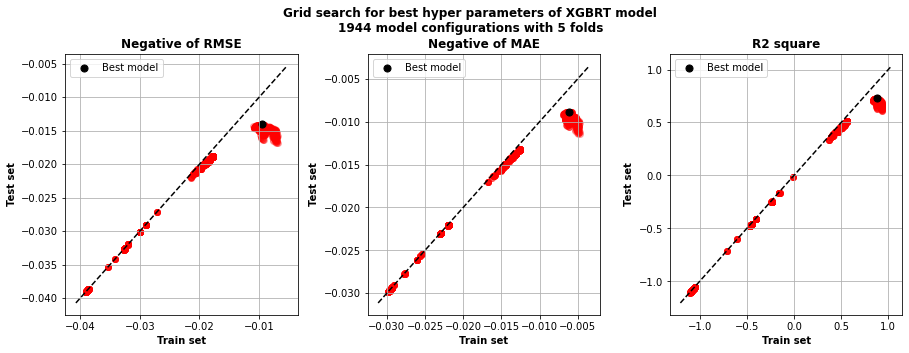

In [16]:
# Make figure.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

# Train and test rmse.
axis = axes[0]
metric = "neg_rmse"
axis.scatter(
    x=df["mean_train_" + metric].values,
    y=df["mean_test_" + metric].values,
    color="red",
    alpha=0.25,
    marker="o"
)
axis.scatter(
    x=df["mean_train_" + metric][search_xgbrt.best_index_],
    y=df["mean_test_" + metric][search_xgbrt.best_index_],
    color="black",
    alpha=1.00,
    marker=".",
    s=200,
    label="Best model"
)
axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
axis.grid()
axis.legend(loc=0)
axis.set_xlabel("Train set", weight="bold")
axis.set_ylabel("Test set", weight="bold")
axis.set_title("Negative of RMSE", weight="bold")

# Train and test mae.
axis = axes[1]
metric = "neg_mae"
axis.scatter(
    x=df["mean_train_" + metric].values,
    y=df["mean_test_" + metric].values,
    color="red",
    alpha=0.25,
    marker="o"
)
axis.scatter(
    x=df["mean_train_" + metric][search_xgbrt.best_index_],
    y=df["mean_test_" + metric][search_xgbrt.best_index_],
    color="black",
    alpha=1.00,
    marker=".",
    s=200,
    label="Best model"
)
axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
axis.grid()
axis.legend(loc=0)
axis.set_xlabel("Train set", weight="bold")
axis.set_ylabel("Test set", weight="bold")
axis.set_title("Negative of MAE", weight="bold")

# Train and test r2.
axis = axes[2]
metric = "r2"
axis.scatter(
    x=df["mean_train_" + metric].values,
    y=df["mean_test_" + metric].values,
    color="red",
    alpha=0.25,
    marker="o"
)
axis.scatter(
    x=df["mean_train_" + metric][search_xgbrt.best_index_],
    y=df["mean_test_" + metric][search_xgbrt.best_index_],
    color="black",
    alpha=1.00,
    marker=".",
    s=200,
    label="Best model"
)
axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
axis.grid()
axis.legend(loc=0)
axis.set_xlabel("Train set", weight="bold")
axis.set_ylabel("Test set", weight="bold")
axis.set_title("R2 square", weight="bold")

# Adjustments.
fig.suptitle(
    f"Grid search for best hyper parameters of XGBRT model\n" + \
    f"{count} model configurations with {cv} folds", 
    weight="bold"
)
plt.subplots_adjust(top=0.85, wspace=0.30)

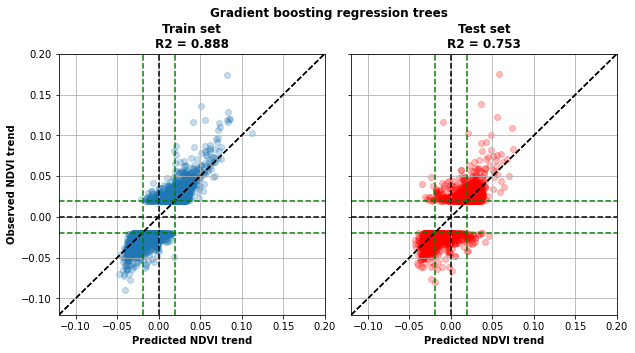

In [17]:
# Scatter plot of train and test scores.
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

# Predictions.
df_y_train_pred = search_xgbrt.best_estimator_.predict(df_x_train)
df_y_test_pred = search_xgbrt.best_estimator_.predict(df_x_test)

# Train!
axes[0].scatter(df_y_train_pred, df_y_train, alpha=0.25)

# Test.
axes[1].scatter(df_y_test_pred, df_y_test, alpha=0.25, color="red")

# Diagonal, horizontal, and vertical lines.
for axis in axes:
    axis.set_ylim((-0.12, 0.20))
    axis.set_xlim((-0.12, 0.20))
    axis.plot(axes[0].get_xlim(), axes[0].get_xlim(), "--k")
    axis.axvline(ls="--", color="black")
    axis.axhline(ls="--", color="black")
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
    axis.axvline(x=-u, lw=1.5, ls="--", color="green")
    axis.axvline(x=u, lw=1.5, ls="--", color="green")
    axis.axhline(y=-u, lw=1.5, ls="--", color="green")
    axis.axhline(y=u, lw=1.5, ls="--", color="green")

# Adjustments.
axes[0].set_ylabel("Observed NDVI trend", weight="bold")
axes[0].set_xlabel("Predicted NDVI trend", weight="bold")
fig.suptitle("Gradient boosting regression trees", weight="bold")
axes[1].set_xlabel("Predicted NDVI trend", weight="bold")
axes[0].set_title("Train set\nR2 = %.3f" %(r2_score(df_y_train, df_y_train_pred)), 
                  weight="bold")
axes[1].set_title("Test set\nR2 = %.3f" %(r2_score(df_y_test, df_y_test_pred)), 
                  weight="bold")
axes[0].grid()
axes[1].grid()
plt.subplots_adjust(top=0.85, wspace=0.10)

## Sign coherence of predictions

CPU times: user 7.92 s, sys: 340 ms, total: 8.26 s
Wall time: 318 ms


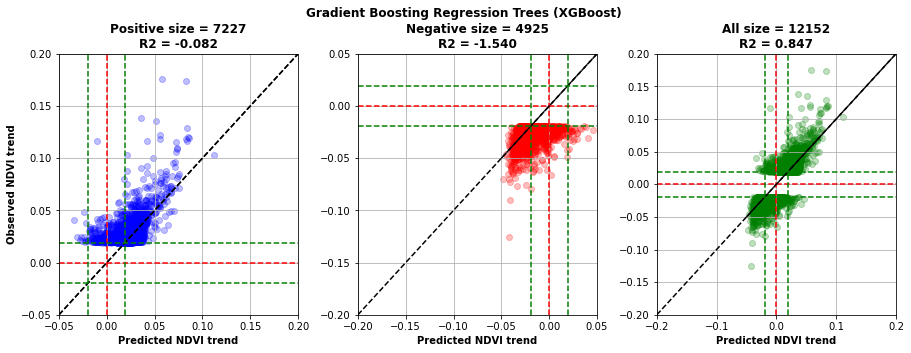

In [18]:
%%time

# Copy.
final_model = search_xgbrt.best_estimator_

# Selecting observed signs.
mask_pos = df_matrix.ndvi_slope > 0
mask_neg = df_matrix.ndvi_slope < 0

# Predictions (as numpy array).
y_pred = final_model.predict(df_matrix[features])

# Make figure.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

# Positive!
axes[0].scatter(y_pred[mask_pos], df_matrix[target][mask_pos], color="blue", alpha=0.25)

# Negative!
axes[1].scatter(y_pred[mask_neg], df_matrix[target][mask_neg], color="red", alpha=0.25)

# All!
axes[2].scatter(y_pred, df_matrix[target], color="green", alpha=0.25)

# Diagonal, horizontal, and vertical lines.
axes[0].set_ylim((-0.05, 0.20))
axes[0].set_xlim((-0.05, 0.20))
axes[1].set_ylim((-0.20, 0.05))
axes[1].set_xlim((-0.20, 0.05))
axes[2].set_ylim((-0.20, 0.20))
axes[2].set_xlim((-0.20, 0.20))
for axis in axes:
    axis.plot(axes[0].get_xlim(), axes[0].get_xlim(), "--k")
    axis.axvline(ls="--", color="red")
    axis.axhline(ls="--", color="red")
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
    axis.axvline(x=-u, lw=1.5, ls="--", color="green")
    axis.axvline(x=u, lw=1.5, ls="--", color="green")
    axis.axhline(y=-u, lw=1.5, ls="--", color="green")
    axis.axhline(y=u, lw=1.5, ls="--", color="green")
    
# Adjustments.
axes[0].set_ylabel("Observed NDVI trend", weight="bold")
axes[0].set_xlabel("Predicted NDVI trend", weight="bold")
fig.suptitle("Gradient Boosting Regression Trees (XGBoost)", weight="bold")
axes[1].set_xlabel("Predicted NDVI trend", weight="bold")
axes[2].set_xlabel("Predicted NDVI trend", weight="bold")
axes[0].set_title("Positive size = %u\nR2 = %.3f" \
                  %(df_matrix[target][mask_pos].size, r2_score(df_matrix[target][mask_pos], y_pred[mask_pos])), 
                  weight="bold")
axes[1].set_title("Negative size = %u\nR2 = %.3f" \
                  %(df_matrix[target][mask_neg].size, r2_score(df_matrix[target][mask_neg], y_pred[mask_neg])), 
                  weight="bold")
axes[2].set_title("All size = %u\nR2 = %.3f" \
                  %(df_matrix[target].size, r2_score(df_matrix[target], y_pred)), 
                  weight="bold")
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.subplots_adjust(top=0.85, wspace=0.25)  

## Permutation feature importances

In [19]:
%%time

# Importance for all grid points.
PI = permutation_importance(
    estimator=final_model,
    X=df_matrix[features],
    y=df_matrix[target],
    scoring="r2",
    n_repeats=10,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
results = PI.importances[order, :]
features_ordered = np.array(features)[order]

# Model score for all grid points.
score = final_model.score(df_matrix[features], df_matrix[target])

# Importance for all NDVI-positively-trendy grid points.
PI_POS = permutation_importance(
    estimator=final_model,
    X=df_matrix[features][mask_pos],
    y=df_matrix[target][mask_pos],
    scoring="r2",
    n_repeats=10,
    n_jobs=-1
)

# Features importances in decreasing order.
order_pos = PI_POS.importances_mean.argsort()[::-1]
results_pos = PI_POS.importances[order_pos, :]
features_ordered_pos = np.array(features)[order_pos]

# Model score for NDVI-positively-trendy grid points.
score_pos = final_model.score(df_matrix[features][mask_pos], df_matrix[target][mask_pos])

# Importance for all NDVI-negatively-trendy grid points.
PI_NEG = permutation_importance(
    estimator=final_model,
    X=df_matrix[features][mask_neg],
    y=df_matrix[target][mask_neg],
    scoring="r2",
    n_repeats=10,
    n_jobs=-1
)

order_neg = PI_NEG.importances_mean.argsort()[::-1]
results_neg = PI_NEG.importances[order_neg, :]
features_ordered_neg = np.array(features)[order_neg]

# Model score for NDVI-negatively-trendy grid points.
score_neg = final_model.score(df_matrix[features][mask_neg], df_matrix[target][mask_neg])

CPU times: user 29.6 s, sys: 1.36 s, total: 31 s
Wall time: 25.9 s


CPU times: user 4.88 s, sys: 200 ms, total: 5.08 s
Wall time: 525 ms


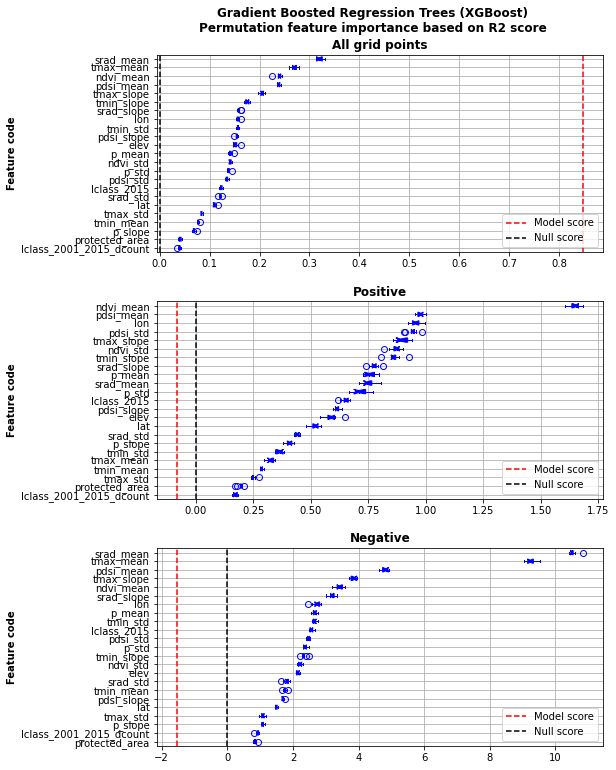

In [20]:
%%time

# Make figure.
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

# All grid points.
ax0.boxplot(
    notch=True,
    x=results.T,
    vert=False,
    labels=features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)
ax0.axvline(score, linestyle="--", color="red", label="Model score")

# Positive trends.
ax1.boxplot(
    notch=True,
    x=results_pos.T,
    vert=False,
    labels=features_ordered_pos,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)
ax1.axvline(score_pos, linestyle="--", color="red", label="Model score")

# Negative trends.
ax2.boxplot(
    notch=True,
    x=results_neg.T,
    vert=False,
    labels=features_ordered_neg,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)
ax2.axvline(score_neg, linestyle="--", color="red", label="Model score")

# Adjustments.
ax0.set_ylabel("Feature code", weight="bold")
ax1.set_ylabel("Feature code", weight="bold")
ax2.set_ylabel("Feature code", weight="bold")
plt.suptitle("Gradient Boosted Regression Trees (XGBoost)\n" + \
             "Permutation feature importance based on R2 score", weight="bold")
ax0.set_title("All grid points", weight="bold")
ax1.set_title("Positive", weight="bold")
ax2.set_title("Negative", weight="bold")
plt.subplots_adjust(hspace=0.25, top=0.925)
for axis in (ax0, ax1, ax2):
    axis.axvline(linestyle="--", color="black", label="Null score")
    axis.invert_yaxis()
    axis.grid()
    axis.legend(loc=4)

## Partial dependence plots

>>> Processing srad_mean ...
>>> Processing tmax_mean ...
>>> Processing ndvi_mean ...
>>> Processing pdsi_mean ...
>>> Processing tmax_slope ...
>>> Processing tmin_slope ...
>>> Processing srad_slope ...
>>> Processing lon ...
>>> Processing tmin_std ...
CPU times: user 1h 1min 53s, sys: 2min 5s, total: 1h 3min 58s
Wall time: 2min 5s


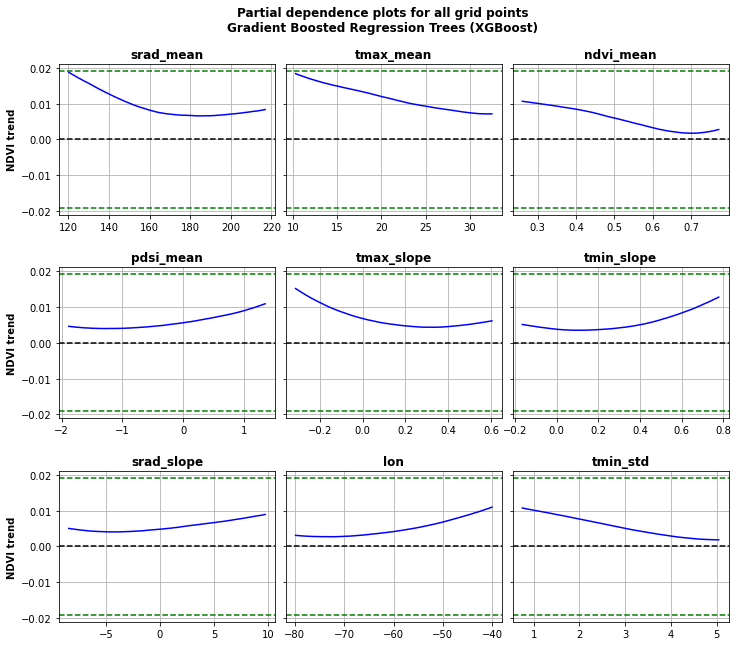

In [21]:
%%time

# Make figure.
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharey=True)
axes = axes.flatten()

# The most important features.
for index, feature in enumerate(features_ordered[:9]):
    
    print(">>> Processing", feature, "...")    
    
    # Partial dependence of a feature (or a set of features) corresponds to
    # the average response of an estimator for each possible value of the
    # feature.
    pdp, fgrid = partial_dependence(
        estimator=final_model,
        X=df_matrix[features],
        features=[str(feature)],
        method="brute",
        percentiles=(0.05, 0.95),
        grid_resolution=100
    )
    
    # Skeleton plot.
    axes[index].plot(fgrid[0], pdp[0], "-b")
    axes[index].set_title(feature, weight="bold")
    axes[index].grid()
    axes[index].axhline(y=-u, lw=1.5, ls="--", color="green")
    axes[index].axhline(y=u, lw=1.5, ls="--", color="green")
    axes[index].axhline(y=0, lw=1.5, ls="--", color="black")
    
    
# Adjustments.    
plt.suptitle("Partial dependence plots for all grid points\n" + \
             "Gradient Boosted Regression Trees (XGBoost)",
             weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35, top=0.90)
axes[0].set_ylabel("NDVI trend", weight="bold")
axes[3].set_ylabel("NDVI trend", weight="bold")
_ = axes[6].set_ylabel("NDVI trend", weight="bold")

## Predicted error distribution

CPU times: user 8.18 s, sys: 312 ms, total: 8.49 s
Wall time: 532 ms


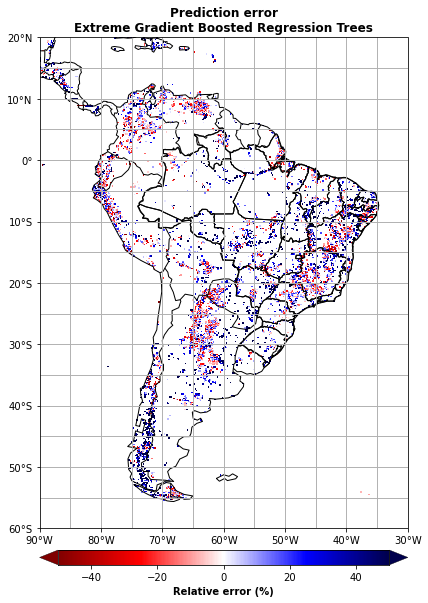

In [22]:
%%time

# Error = (Ytrue - Ypred) *100 / Ytrue.
sca = 1.10
axgr = cdlearn.maps.south_america(
    figsize=(6 * sca, 12 * sca), 
    nrows_ncols=(1, 1),
    axes_pad=0.05,
    titles=["Prediction error\nExtreme Gradient Boosted Regression Trees"],
    cbar_mode="single",
    cbar_location="bottom"
)

# As pandas DataFrame object.
num = (df_matrix[target].values.flatten() - final_model.predict(df_matrix[features]))
den = df_matrix[target].values.flatten()
error = 100 * np.divide(num, den, out=np.nan * np.ones_like(den), where=den!=0)
error = pd.DataFrame(data=error, columns=["error"])
error["lat"] = df_matrix["lat"].values
error["lon"] = df_matrix["lon"].values
error = error.set_index(keys=["lat", "lon"])

# Convert to xarray Dataset object.
error = error.to_xarray()

# Data on map.
p = error.error.plot(
    ax=axgr[0],
    vmin=-50,
    vmax=50,
    cmap=plt.cm.seismic_r,
    add_colorbar=False,
    add_labels=False
)

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="both")
cb.set_label_text("Relative error (%)", weight="bold") 

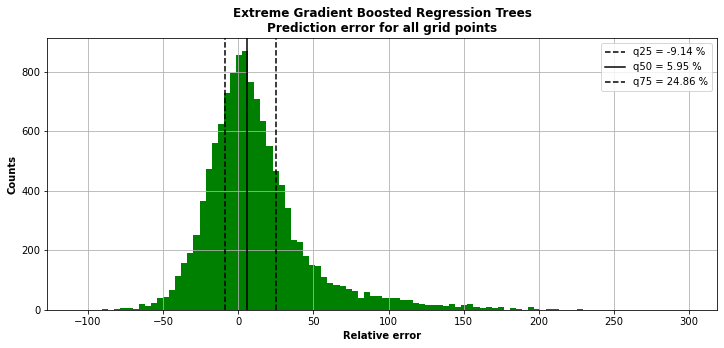

In [23]:
# Quantiles.
err = error.error.values.flatten()
err = err[~np.isnan(err)]
q25, q50, q75 = np.quantile(err, q=[0.25, 0.50, 0.75])

# Make figure.
plt.figure(figsize=(12, 5))
plt.hist(err, bins=100, color="green")
plt.axvline(x=q25, ls="--", color="black", label=str("q25 = %.2f %%" %(q25)))
plt.axvline(x=q50, ls="-", color="black", label=str("q50 = %.2f %%" %(q50)))
plt.axvline(x=q75, ls="--", color="black", label=str("q75 = %.2f %%" %(q75)))
plt.title("Extreme Gradient Boosted Regression Trees\nPrediction error for all grid points", 
          weight="bold")
plt.xlabel("Relative error", weight="bold")
plt.ylabel("Counts", weight="bold")
plt.legend()
plt.grid();

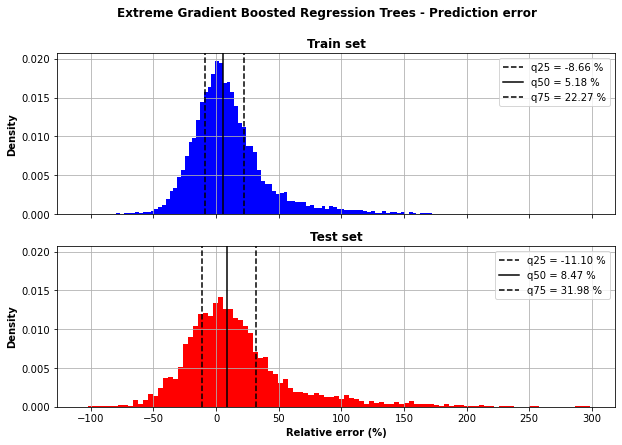

In [24]:
# Train error as pandas DataFrame object.
num = (df_y_train.ndvi_slope.values - final_model.predict(df_x_train))
den = df_y_train.ndvi_slope.values
error_train = 100 * np.divide(num, den, out=np.nan * np.ones_like(den), where=den!=0)

# Train error as pandas DataFrame object.
num = (df_y_test.ndvi_slope.values - final_model.predict(df_x_test))
den = df_y_test.ndvi_slope.values
error_test = 100 * np.divide(num, den, out=np.nan * np.ones_like(den), where=den!=0)

# Quantiles.
error_train = error_train[~np.isnan(error_train)]
error_test = error_test[~np.isnan(error_test)]
q25_train, q50_train, q75_train = np.quantile(error_train, q=[0.25, 0.50, 0.75])
q25_test, q50_test, q75_test = np.quantile(error_test, q=[0.25, 0.50, 0.75])

# Make figure.
fig, axes = plt.subplots(2, 1, figsize=(10, 6.5), sharex=True, sharey=True)
axes = axes.flatten()
axes[0].hist(error_train, bins=100, density=True, color="blue")
axes[1].hist(error_test, bins=100, density=True, color="red")
axes[0].axvline(x=q25_train, ls="--", color="black", label=str("q25 = %.2f %%" %(q25_train)))
axes[0].axvline(x=q50_train, ls="-", color="black", label=str("q50 = %.2f %%" %(q50_train)))
axes[0].axvline(x=q75_train, ls="--", color="black", label=str("q75 = %.2f %%" %(q75_train)))
axes[1].axvline(x=q25_test, ls="--", color="black", label=str("q25 = %.2f %%" %(q25_test)))
axes[1].axvline(x=q50_test, ls="-", color="black", label=str("q50 = %.2f %%" %(q50_test)))
axes[1].axvline(x=q75_test, ls="--", color="black", label=str("q75 = %.2f %%" %(q75_test)))
axes[1].set_xlabel("Relative error (%)", weight="bold")
axes[0].set_ylabel("Density", weight="bold")
axes[1].set_ylabel("Density", weight="bold")
axes[0].set_title("Train set", weight="bold")
axes[1].set_title("Test set", weight="bold")
axes[0].grid()
axes[1].grid()
axes[0].legend()
axes[1].legend()
_ = fig.suptitle(
    "Extreme Gradient Boosted Regression Trees - Prediction error", 
    weight="bold"
)